<a href="https://colab.research.google.com/github/aditya-vaish5/nnfl_term_project/blob/master/Copy_of_nnfl_termproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi

--2020-05-25 14:15:51--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13603614 (13M) [text/plain]
Saving to: ‘train.en.1’

train.en.1          100%[===================>]  12.97M  7.49MB/s    in 1.7s    

2020-05-25 14:15:53 (7.49 MB/s) - ‘train.en.1’ saved [13603614/13603614]

--2020-05-25 14:15:55--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18074646 (17M) [text/plain]
Saving to: ‘train.vi.1’

train.vi.1          100%[===================>]  17.24M  9.92MB/s    in 1.7s    

2020-05-25 14:15:57 (9.92 MB/s) - ‘train.vi.1’ saved [18074646/18074646]



In [0]:
import numpy as np
import csv
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

In [0]:
source_sent = []
target_sent = []

test_source_sent = []
test_target_sent = []


with open('train.en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        # discarding first 20 translations as there was some
        # english to english translations found in the first few. which are wrong
        if l_i<50:
            continue
        source_sent.append(line)
        
            
with open('train.vi', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        if l_i<50:
            continue
        target_sent.append(line)


with open('tst2013.en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        test_source_sent.append(line)
                    
with open('tst2013.vi', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        test_target_sent.append(line)
            
assert len(source_sent) == len(target_sent),'Source: %d, Target: %d'%(len(source_sent),len(target_sent))
assert len(test_source_sent) == len(test_target_sent), 'Source: %d, Target: %d'%(len(test_source_sent), len(test_target_sent))
print('Sample translations (%d)'%len(source_sent))
for i in range(0,len(source_sent),10000):
    print('(',i,') EN: ', source_sent[i])
    print('(',i,') VI: ', target_sent[i])

Sample translations (133267)
( 0 ) EN:  In each one of those assessments that we write , we always tag on a summary , and the summary is written for a non-scientific audience .

( 0 ) VI:  Trong mỗi bản đánh giá chúng tôi viết , chúng tôi luôn đính kèm một bản tóm lược , được viết cho những độc giả không chuyên về khoa học .

( 10000 ) EN:  This is an area in the prefrontal cortex , a region where we can use cognition to try to overcome aversive emotional states .

( 10000 ) VI:  Đây là một khu vực trong vỏ não trước trán , vùng mà chúng sử dụng tri thức cho việc thử vượt qua trạng thái cảm xúc ác cảm .

( 20000 ) EN:  And there are flowers that are self-infertile . That means they can &apos;t -- the pollen in their bloom can &apos;t fertilize themselves .

( 20000 ) VI:  có những loài hoa không thể tự thụ phấn . Nghĩa là chúng không thể -- phấn hoa của nó không thể tụ thụ phấn được

( 30000 ) EN:  And a lot of this comes together in a philosophy of change that I find really is powerfu

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-25 14:16:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-25 14:16:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-25 14:16:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
!apt install gzip
import gzip
!unzip glove*.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gzip is already the newest version (1.6-5ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!ls

6B.200.dat	  6B.50_words.pkl    glove.6B.zip    train.vi	   tst2013.vi.1
6B.200_idx.pkl	  glove.6B.100d.txt  glove.6B.zip.1  train.vi.1
6B.200_words.pkl  glove.6B.200d.txt  sample_data     tst2013.en
6B.50.dat	  glove.6B.300d.txt  train.en	     tst2013.en.1
6B.50_idx.pkl	  glove.6B.50d.txt   train.en.1      tst2013.vi


In [0]:
!pip install bcolz

In [0]:
import bcolz
import pickle
import copy
import operator
from pandas import DataFrame

In [0]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir='/content/6B.200.dat', mode='w')
with open('/content/glove.6B.200d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
     
vectors = bcolz.carray(vectors[1:].reshape((400000, 200)), rootdir='/content/6B.200.dat', mode='w')
vectors.flush()
pickle.dump(words, open('/content/6B.200_words.pkl', 'wb'))
pickle.dump(word2idx, open('/content/6B.200_idx.pkl', 'wb'))

In [0]:
vectors = bcolz.open('/content/6B.200.dat')[:]
words = pickle.load(open('/content/6B.200_words.pkl', 'rb'))
word2idx = pickle.load(open('/content/6B.200_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [0]:
glove_dframe = DataFrame(vectors, columns=range(1,201), index=words)
print(glove_dframe.shape)
glove_dframe[0:10]

(400000, 200)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
the,-0.071549,0.093459,0.023738,-0.090339,0.056123,0.32547,-0.397960,-0.092139,0.061181,-0.189500,0.130610,0.14349,0.011479,0.381580,0.540300,-0.140880,0.243150,0.230360,-0.553390,0.048154,0.456620,3.2338,0.020199,0.049019,-0.014132,0.076017,-0.115270,0.200600,-0.077657,0.243280,0.163680,-0.341180,-0.066070,0.101520,0.038232,-0.176680,-0.88153,-0.33895,-0.035481,-0.550950,...,-0.042910,-0.067897,-0.293320,0.109780,-0.045365,0.232220,-0.311340,-0.289830,-0.666870,0.53097,0.194610,0.366700,0.26185,-0.651870,0.102660,0.113630,-0.129530,-0.682460,-0.187510,0.147600,1.07650,-0.229080,-0.009343,-0.206510,-0.352250,-0.267200,-0.003431,0.25906,0.217590,0.661580,0.121800,0.199570,-0.20303,0.344740,-0.243280,0.131390,-0.008877,0.336170,0.030591,0.255770
",",0.176510,0.292080,-0.002077,-0.375230,0.004914,0.23979,-0.288930,-0.014643,-0.109930,0.155920,0.206270,0.47675,0.099907,-0.140580,0.211140,0.121260,-0.318310,-0.089433,-0.090553,-0.319620,0.213190,2.4844,-0.077521,-0.084279,0.201860,0.260840,-0.404110,-0.191270,0.247150,0.223940,-0.063437,0.203790,-0.184630,-0.088413,0.024169,-0.287690,-0.61246,-0.12683,-0.088273,0.183310,...,0.026823,-0.045444,-0.226420,-0.199770,-0.121380,0.169410,0.061998,0.426310,-0.088383,0.45756,0.077774,0.061342,0.45710,-0.177870,-0.145970,0.326540,0.002443,-0.118860,0.100810,-0.020011,1.03660,-0.398140,-0.681800,0.236850,-0.203960,-0.176680,-0.313850,0.14834,-0.052187,0.061300,-0.325820,0.191530,-0.15469,-0.146790,0.046971,0.032325,-0.220060,-0.207740,-0.231890,-0.108140
.,0.122890,0.580370,-0.069635,-0.502880,0.105030,0.39945,-0.386350,-0.084279,0.122190,0.080312,0.323370,0.47579,-0.038375,-0.007090,0.415240,0.321210,-0.211850,0.361440,-0.055623,-0.030512,0.428540,2.8547,-0.146230,-0.175570,0.311970,-0.131180,0.033298,0.130930,0.089889,-0.124170,0.002340,-0.068954,-0.107540,-0.115510,-0.310520,-0.120970,-0.46691,-0.08360,-0.037664,-0.071779,...,0.075441,0.082116,-0.460080,0.012393,-0.025310,0.141770,-0.092192,0.345050,-0.521360,0.57304,0.011973,0.033196,0.29672,-0.278990,0.199790,0.256660,0.082079,-0.078436,0.093719,0.242020,1.34950,-0.304340,-0.309360,0.420470,-0.079068,-0.148190,-0.089404,0.06680,0.224050,0.272260,-0.035236,0.176880,-0.05360,0.007003,-0.033006,-0.080021,-0.244510,-0.039174,-0.162360,-0.096652
of,0.052924,0.254270,0.313530,-0.356130,0.029629,0.51034,-0.107160,0.151950,0.057698,0.061490,0.061160,0.39911,-0.000290,0.319780,0.432570,-0.147080,0.054842,0.270790,-0.140510,-0.301010,0.163130,3.0013,0.222310,-0.142790,0.083705,0.089866,-0.527060,-0.089661,0.273110,0.314130,-0.040810,0.060557,-0.042656,0.241780,-0.291870,0.225750,-0.62980,-0.14641,-0.224290,-0.056621,...,0.405320,-0.027960,-0.133980,-0.110860,0.059506,0.240520,-0.597390,-0.002407,-0.185930,1.04200,-0.129690,0.208130,0.33305,-0.127800,0.085662,-0.076422,0.314070,-0.237840,-0.054838,0.011369,0.84500,-0.341650,0.093983,0.082445,-0.277770,-0.442260,-0.063078,0.37274,0.054468,0.241970,-0.040886,0.389400,-0.10509,0.233720,0.096027,-0.303240,0.244880,-0.086254,-0.419170,0.464960
to,0.573460,0.541700,-0.234770,-0.362400,0.403700,0.11386,-0.449330,-0.309910,-0.005341,0.584260,-0.025956,0.49393,-0.037209,-0.284280,0.097696,-0.489070,0.026027,0.376490,0.057788,-0.468070,0.081288,3.2825,-0.636900,0.379560,0.003817,0.093607,-0.128550,0.173800,0.105220,0.286480,0.210890,-0.470760,0.027733,-0.198030,0.076328,-0.846290,-0.79708,-0.38743,-0.030422,-0.268490,...,-0.124130,-0.344310,-0.232960,-0.211870,0.085387,0.070063,-0.198030,-0.026023,-0.390370,0.80002,0.405770,-0.079863,0.35263,-0.340430,0.396760,0.228620,-0.350280,-0.473440,0.597420,-0.116570,1.05520,-0.415700,-0.080552,-0.056571,-0.166220,0.192740,-0.095175,-0.20781,0.156200,0.050231,-0.279150,0.437420,-0.31237,0.131940,-

In [0]:
# for moving 'sos' token at index 0 and 'eos' token at index 1
 
sos_index = word2idx['sos']
eos_index = word2idx['eos']
sos_swap_word = words[0]
eos_swap_word = words[1]
 
words[0], words[sos_index] = words[sos_index], words[0]
words[1], words[eos_index] = words[eos_index], words[1]
word2idx[sos_swap_word], word2idx['sos'] = word2idx['sos'], word2idx[sos_swap_word]
word2idx[eos_swap_word], word2idx['eos'] = word2idx['eos'], word2idx[eos_swap_word]

In [0]:
# Sort Word2idx
word2idx = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
print(device)

cuda


In [0]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        if(name == 'eng'):
          self.word2index = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}
          self.word2index["unk"] = 400000 
          self.word2count = { word : 1 for word in words }
          self.index2word = { i : word for word, i in word2idx.items() }
          self.n_words = 400001
        else:
          self.word2index = {}
          self.word2count = {}
          self.index2word = {0: "sos", 1: "eos"}
          self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
MAX_LENGTH = 100

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
def prepareData(lang1, lang2, source_arr, target_arr):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = [];
    for i in range(0,len(target_arr)):
      pairs.append([normalizeString(source_arr[i]), normalizeString(target_arr[i])])
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [0]:
input_lang, output_lang, pairs_train = prepareData('eng', 'vi', source_sent, target_sent)
print(random.choice(pairs_train))

Read 133267 sentence pairs
Trimmed to 132670 sentence pairs
Counting words...
Counted words:
eng 402460
vi 14127
['and here look the above question is put bluntly quot are video games art ? no . video games aren apos t art because they are quite thoroughly something else code . quot ', 'hay xem nhung cau hoi tren ay uoc hoi rat thang thung quot video game la nghe thuat u ? khong chung khong phai la nghe thuat vi chung hoan toan la thu gi o rat khac oan ma . quot ']


In [0]:
# create a new tensor with all embeddings for english using glove dictionary
matrix_len = input_lang.n_words
 
weights_matrix = np.zeros((matrix_len, 200))
words_found = 0
print(input_lang.n_words)
print(len(input_lang.word2index))
for i, word in enumerate(input_lang.word2index):
    try: 
        weights_matrix[i-2] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i-2] = np.random.normal(scale=0.6, size=(200, ))

402460
402459


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.input_size = input_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional = True)

    def forward(self, input, hidden, cell_state):
        # print("forward running")
        # print(self.embedding(input).size())
        output = self.embedding(input).view(1, 1, -1)
        # output, (hidden, cell_state) = self.lstm(output)
        output, (hidden, cell_state) = self.lstm(output, (hidden, cell_state))
        # print(output.size())
        return output, hidden, cell_state

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device = device)
    def initcellstate(self):
      return torch.zeros(2, 1, self.hidden_size, device = device)

In [0]:
# THIS CLASS ISN'T USED IN EVALUATION
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,bidirectional =True)
        self.out = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden,cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden,cell_state = self.lstm(output, (hidden,cell_state))
        output = self.softmax(self.out(output[0]))
        return output, hidden,cell_state

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    def initcellstate(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

In [0]:
MAX_LENGTH = 100
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size,bidirectional =True)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, cell_state, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # print(attn_weights.unsqueeze(0).size(), encoder_outputs.unsqueeze(0).size())
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # print(embedded[0].size(),attn_applied[0].size())
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell_state) = self.lstm(output, (hidden, cell_state))

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell_state, attn_weights

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device = device)
    def initcellstate(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

In [0]:
def indexesFromSentence(lang, sentence):
    arr = [];
    for word in sentence.split(' '):
        try:
          arr.append(lang.word2index[word])
        except:
          arr.append(lang.word2index["unk"])
    return arr

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initcellstate()
    # print("setting optimizers to zero grad")
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # print("INPUT SIZE: ", input_tensor.size())
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)

    loss = 0

    for ei in range(input_length):
      # print("starting encoder for " , ei)
      encoder_output, encoder_hidden, encoder_cell = encoder(
          input_tensor[ei], encoder_hidden, encoder_cell)
      # print(encoder_output)
      encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    for di in range(target_length):
      # print("decoder for di : ", di)
      decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
          decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # detach from history as input

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
          break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def trainIters(encoder, decoder, n_iters, pairs, print_every=1000, plot_every=100, learning_rate=0.1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # print("train Iter optimizers set")
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    # print("training pairs for this iteration have been assigned")
    # print("training pairs size")
    # print(len(training_pairs))
    # print(len(training_pairs[0]))
    # print(len(training_pairs[0][0]))
    # print(len(training_pairs[0][0]))
    # print(training_pairs[0][0])
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        # print(iter , " : printing iter-1 th training pair")
        # print(training_pair)
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # if (iter % 100 == 0):
        #     print(input_tensor)
        # print(iter , " : started training with above tensors")

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        # print(iter," : current iter ended");
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Encoder initialization done
Decoder initialization done
1m 0s (- 3m 2s) (250 25%) 3.3340
1m 59s (- 1m 59s) (500 50%) 3.0075
3m 1s (- 1m 0s) (750 75%) 2.8548
3m 58s (- 0m 0s) (1000 100%) 3.0584


<Figure size 432x288 with 0 Axes>

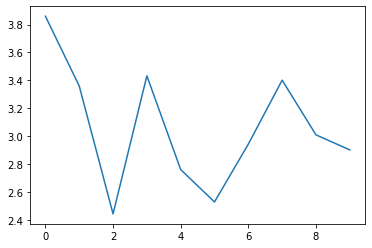

In [0]:
hidden_size = 200
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
print("Encoder initialization done")
# attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
print("Decoder initialization done")

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 1000, pairs_train, print_every=250)

In [0]:
input_lang_test, output_lang_test, pairs_test = prepareData('eng', 'vi', test_source_sent, test_target_sent)
print(random.choice(pairs_test))

Read 1268 sentence pairs
Trimmed to 1265 sentence pairs
Counting words...
Counted words:
eng 400032
vi 1104
['as soon as we moved to new england you know that place where connor was supposed to feel so safe he bought three guns .', 'khi chung toi chuyen en new england ban biet ay noi ma conor dua vao e cam thay an toan anh ta mua ba cay sung']


In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initcellstate()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden,encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden,encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden,decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1,:ei + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n = 5):
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
evaluateRandomly(encoder1, attn_decoder1)

> i had my first apartment my first little green american express card and i had a very big secret .
= lan au tien toi co can ho the tin dung american express cua rieng minh va toi a co bi mat lon .
<  ta la ta <EOS>

> so i didn apos t give up . i continued .
= nhung toi khong tu bo . toi tiep tuc suy nghi .
<  ta la ta <EOS>

> so what happened ?
= vay ieu gi a xay ra ?
<  ta la ta <EOS>

> thus began my journey into modern day slavery .
= va tu o bat au cuoc hanh trinh tien vao the gioi no le hien ai
<  ta la ta <EOS>

> and they apos re both accurate . okay but in addition voice based tests are non expert .
= va ca hai eu chuan xac . nhung them mot ieu thu nghiem dua tren giong noi khong co tinh chuyen mon .
<  ta la ta <EOS>



In [0]:
# for i in range(50):
#   sent = random.choice(pairs_test)[0]
#   output_words, attentions = evaluate(
#       encoder1, attn_decoder1, sent)
#   print(attentions.size(), sent)

input = today apos s slavery is about commerce so the goods that enslaved people produce have value but the people producing them are disposable .
output = toi toi toi toi toi toi toi toi toi toi toi toi toi co toi va . toi va . . . <EOS>


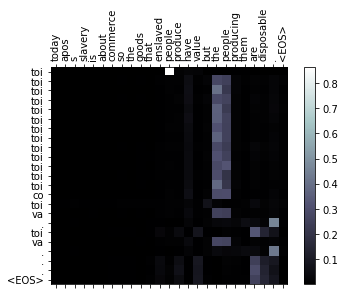

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(random.choice(pairs_test)[0])


1. BiLSTM
2. GloVE embedding
3. presentation
4. BLUE Score and how error is calculated here
5. Figure out how attention figures are made.`
